In [1]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import tqdm
import torch
import torch.nn as nn
import dgl

Using backend: pytorch


In [2]:
import sys
sys.path.append("../PhenixML/")

In [3]:
# get molecules
from pathlib import Path
mol_dir = Path("/dev/shm/cschlick/geostd_passed")
#mol_dir = Path("/dev/shm/cschlick/csd_passed/")
mol_files = [file for file in mol_dir.glob("**/*") if file.suffix == ".mol"][:1000]
print("Total MOL2 files:",len(mol_files))


Total MOL2 files: 1000


In [4]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # suppress rdkit outpt
mols = [Chem.MolFromMolFile(str(mol_file),removeHs=False) for mol_file in mol_files]

In [5]:
from molgraph.MolGraph import MolGraph

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<unsigned int, std::allocator<unsigned int> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.


In [6]:
mol = mols[0]
molgraph = MolGraph(mol,levels=["n1","n2","n3"])
molgraph.heterograph

Graph(num_nodes={'g': 1, 'n1': 17, 'n2': 34, 'n3': 50},
      num_edges={('g', 'g_has_n1', 'n1'): 17, ('g', 'g_has_n2', 'n2'): 34, ('g', 'g_has_n3', 'n3'): 50, ('n1', 'n1_as_0_in_n2', 'n2'): 34, ('n1', 'n1_as_0_in_n3', 'n3'): 50, ('n1', 'n1_as_1_in_n2', 'n2'): 34, ('n1', 'n1_as_1_in_n3', 'n3'): 50, ('n1', 'n1_as_2_in_n3', 'n3'): 50, ('n1', 'n1_in_g', 'g'): 17, ('n1', 'n1_neighbors_n1', 'n1'): 34, ('n2', 'n2_as_0_in_n3', 'n3'): 50, ('n2', 'n2_as_1_in_n3', 'n3'): 50, ('n2', 'n2_in_g', 'g'): 34, ('n3', 'n3_in_g', 'g'): 50},
      metagraph=[('g', 'n1', 'g_has_n1'), ('g', 'n2', 'g_has_n2'), ('g', 'n3', 'g_has_n3'), ('n1', 'n2', 'n1_as_0_in_n2'), ('n1', 'n2', 'n1_as_1_in_n2'), ('n1', 'n3', 'n1_as_0_in_n3'), ('n1', 'n3', 'n1_as_1_in_n3'), ('n1', 'n3', 'n1_as_2_in_n3'), ('n1', 'g', 'n1_in_g'), ('n1', 'n1', 'n1_neighbors_n1'), ('n2', 'n3', 'n2_as_0_in_n3'), ('n2', 'n3', 'n2_as_1_in_n3'), ('n2', 'g', 'n2_in_g'), ('n3', 'g', 'n3_in_g')])

In [7]:
molgraphs = []
for mol in tqdm.tqdm(mols):
  try:
    molgraphs.append(MolGraph(mol,levels=["n1","n2","n3"]))
  except:
    pass

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.26it/s]


In [8]:
batch = dgl.batch([molgraph.heterograph for molgraph in molgraphs]) 

In [9]:
from molgraph.esp_fragments.sequential import EspSequential
from molgraph.esp_fragments.pooling import EspJanossyPooling


n_units = 128
n_layers = 3
config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
  
sc = lambda in_feats,out_feats: dgl.nn.pytorch.conv.sageconv.SAGEConv(in_feats,out_feats,"mean",bias=True) # dgl saveconv layer

representation = EspSequential(
    feature_units=molgraphs[0].homograph.ndata["h0"].shape[1],
    layer=sc, # use SAGEConv implementation in DGL
    #layer=esp.nn.dgl_legacy.gn("SAGEConv"),
    config=config,
)  

n_units = 128
n_layers = 2
config = []
for n_layer in range(n_layers):
  config+=[n_units,"relu"]
  
readout = EspJanossyPooling(
    in_features=n_units, config=config,
    out_features={              
        #1: {"xyz": 3},
         3: {"eq":1}
        #3: {"eq": 1},
        #4: {"cmplx": 2},
        #4: {"tor": 1},
        },
)

model = nn.Sequential(representation,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)

In [10]:
representation(batch)

Graph(num_nodes={'g': 1000, 'n1': 23865, 'n2': 51062, 'n3': 71452},
      num_edges={('g', 'g_has_n1', 'n1'): 23865, ('g', 'g_has_n2', 'n2'): 51062, ('g', 'g_has_n3', 'n3'): 71452, ('n1', 'n1_as_0_in_n2', 'n2'): 51062, ('n1', 'n1_as_0_in_n3', 'n3'): 71452, ('n1', 'n1_as_1_in_n2', 'n2'): 51062, ('n1', 'n1_as_1_in_n3', 'n3'): 71452, ('n1', 'n1_as_2_in_n3', 'n3'): 71452, ('n1', 'n1_in_g', 'g'): 23865, ('n1', 'n1_neighbors_n1', 'n1'): 51062, ('n2', 'n2_as_0_in_n3', 'n3'): 71452, ('n2', 'n2_as_1_in_n3', 'n3'): 71452, ('n2', 'n2_in_g', 'g'): 51062, ('n3', 'n3_in_g', 'g'): 71452},
      metagraph=[('g', 'n1', 'g_has_n1'), ('g', 'n2', 'g_has_n2'), ('g', 'n3', 'g_has_n3'), ('n1', 'n2', 'n1_as_0_in_n2'), ('n1', 'n2', 'n1_as_1_in_n2'), ('n1', 'n3', 'n1_as_0_in_n3'), ('n1', 'n3', 'n1_as_1_in_n3'), ('n1', 'n3', 'n1_as_2_in_n3'), ('n1', 'g', 'n1_in_g'), ('n1', 'n1', 'n1_neighbors_n1'), ('n2', 'n3', 'n2_as_0_in_n3'), ('n2', 'n3', 'n2_as_1_in_n3'), ('n2', 'g', 'n2_in_g'), ('n3', 'g', 'n3_in_g')])

In [11]:
def loss_fn(g):
  # a heterograph
  metric = torch.nn.MSELoss()
  loss = metric(g.nodes["n3"].data["eq"],g.nodes["n3"].data["eq_ref"])
  return loss

In [12]:
batch = batch.to("cuda:2")
model = model.to("cuda:2")


In [17]:
epoch_losses = []
n_epoch=1000
avg_loss = "inf"

for epoch in tqdm.tqdm(range(n_epoch)):
    
  g = model(batch)
  loss = loss_fn(g)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.62it/s]


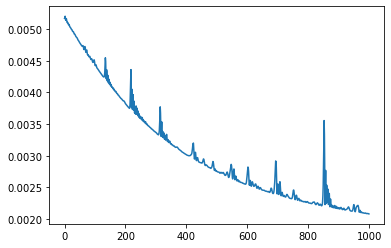

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def to_np(tensor):
  return tensor.detach().cpu().numpy()

plt.plot(epoch_losses)
#plt.plot(loss_history_n3[10:])

In [19]:
import pandas as pd
import seaborn as sns



def plot_geom_eval(a,b,mode="angle",s=0.01):
  

    
  fig, axs = plt.subplots(1,2,figsize=(16,5))
  axs = axs.flatten()
  
  # scatter plot
  ax = axs[0]
  ax.scatter(a,b,s=s)
  #sns.kdeplot(a,b,fill=True)
  if mode == "bond":
    ax.set_xlim(1,1.8)
    ax.set_ylim(1,1.8)
  elif mode == "angle":
    ax.set_xlim(50,140)
    ax.set_ylim(50,140)
  ax.plot([0,200],[0,200],color="black")
  ax.set_xlabel("Experimental",fontsize=14)
  
  # historgram
  ax = axs[1]
  sns.histplot(a-b,ax=ax,kde=True,stat="density")
  if mode == "bond":
    ax.set_xlim(-3,3)
  elif mode == "angle":
    ax.set_xlim(-20,20)


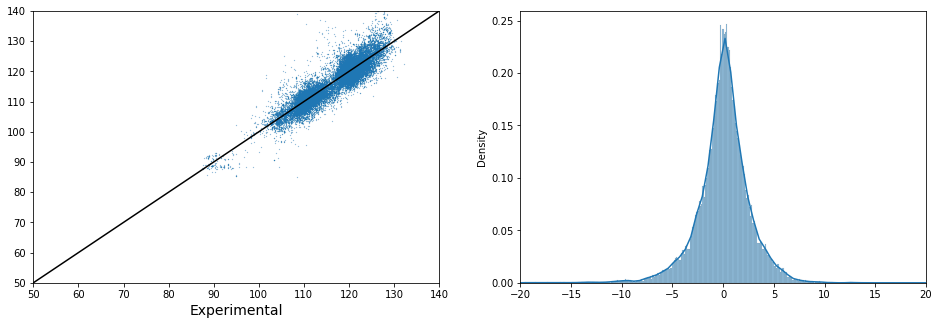

In [20]:
a,b = g.nodes["n3"].data["eq"],g.nodes["n3"].data["eq_ref"]
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,s=0.01,mode="angle")

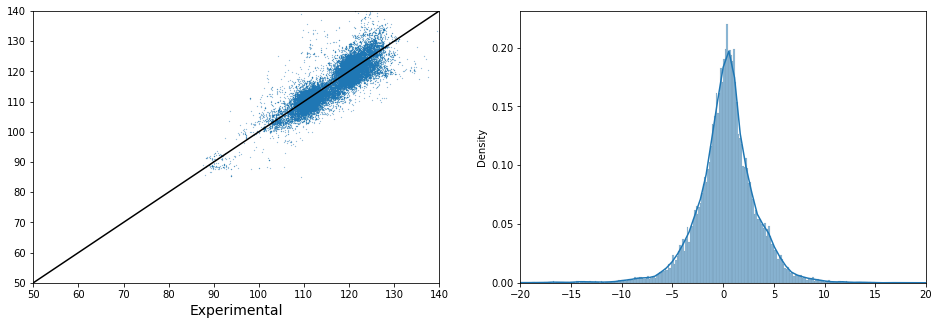

In [24]:
a,b = g.nodes["n3"].data["eq"],g.nodes["n3"].data["eq_ref"]
a,b = to_np(a).flatten(),to_np(b).flatten()
a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,s=0.01,mode="angle")

In [15]:
# prevous results

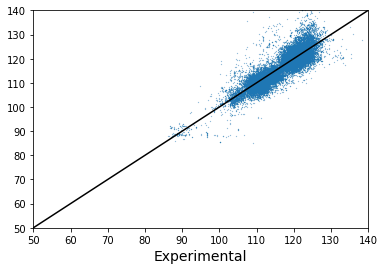

In [25]:
a,b = g.nodes["n3"].data["eq"],g.nodes["n3"].data["eq_ref"]
plot_geom_eval(a,b,s=0.01,mode="angle",to_degrees=True)